<a href="https://colab.research.google.com/github/SnowTrash/pyHikethroug/blob/main/Practica_4_Gradiente_descendiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [13]:
pip install pyDOE

In [14]:
pip install sobol_seq

In [15]:
pip install scipy

In [16]:
pip install pyDOE2

In [17]:
pip install pyswarm

In [18]:
pip install matplotlib

## Main code

Running DE with LHS sampling...


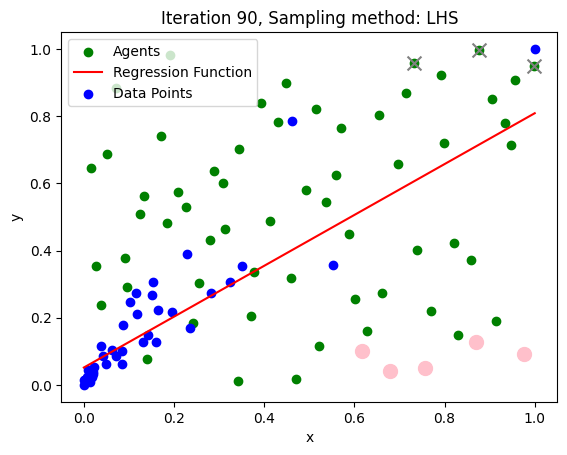

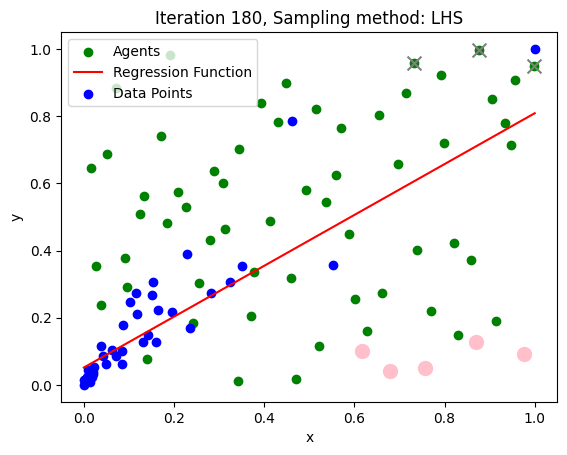

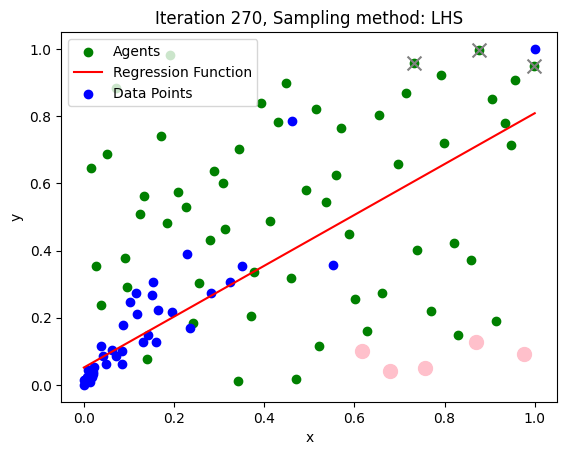

Iteration: 300
Iteration: 301
Test MSE: 790955.838679


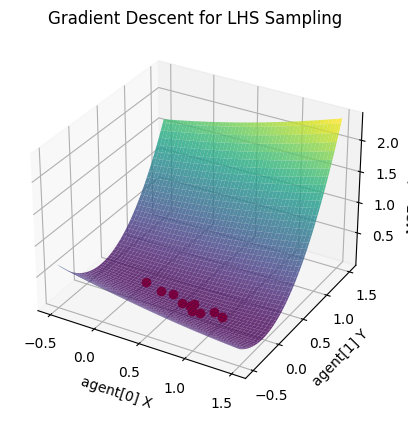

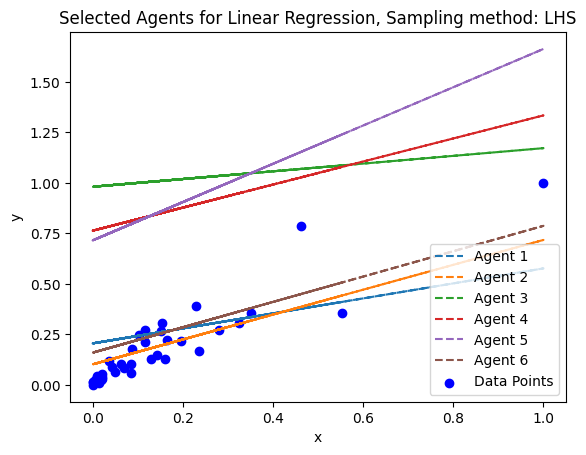

Running DE with Sobol sampling...


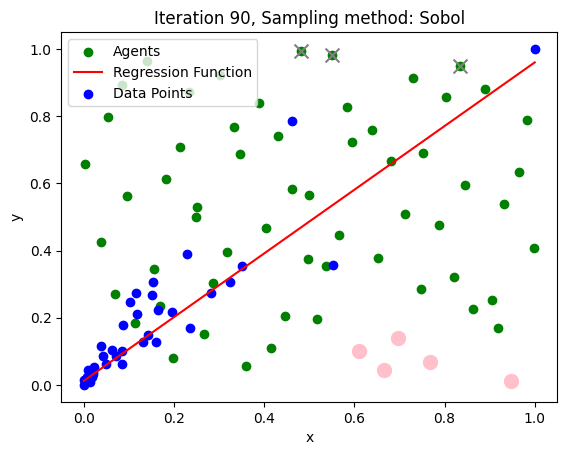

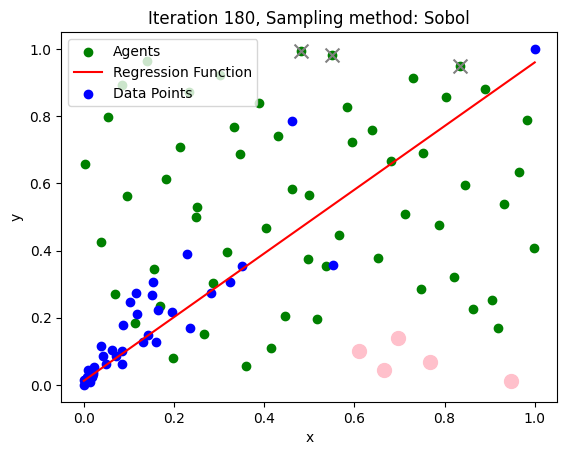

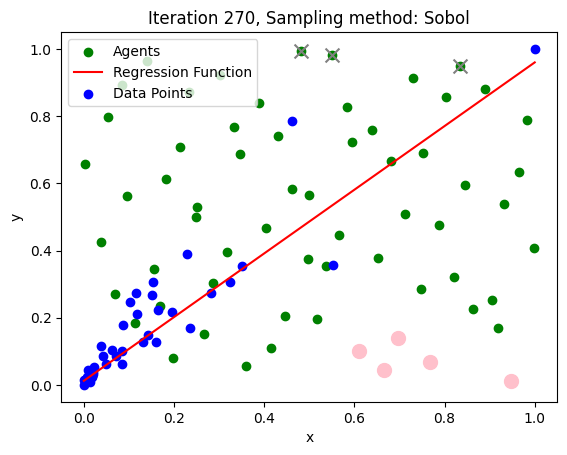

Iteration: 300
Iteration: 301
Test MSE: 871414.519430


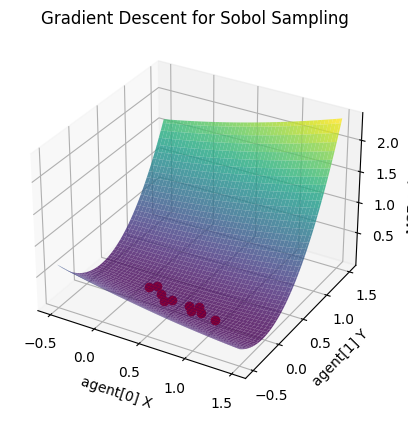

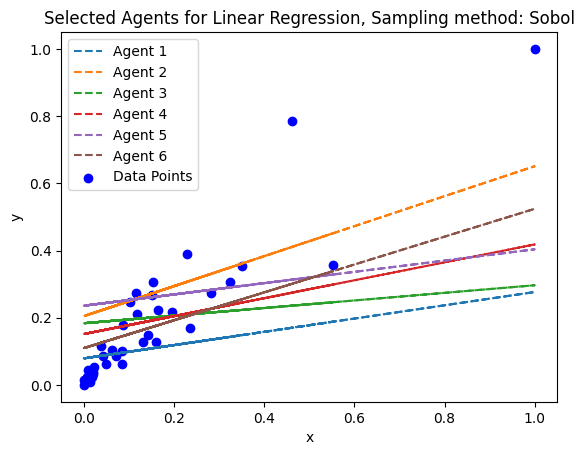

Running DE with Halton sampling...


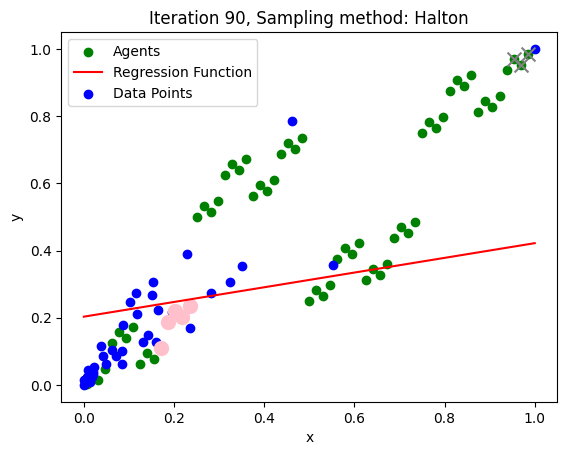

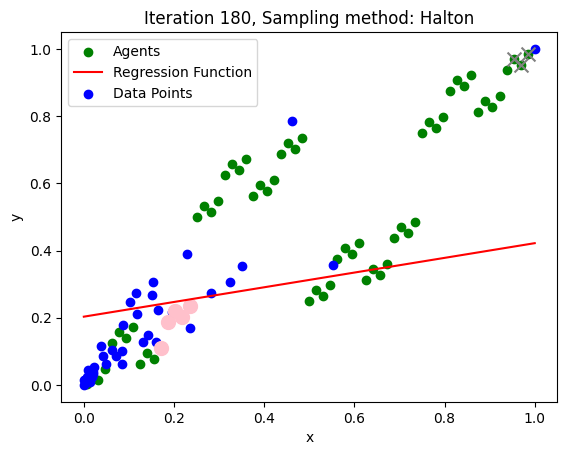

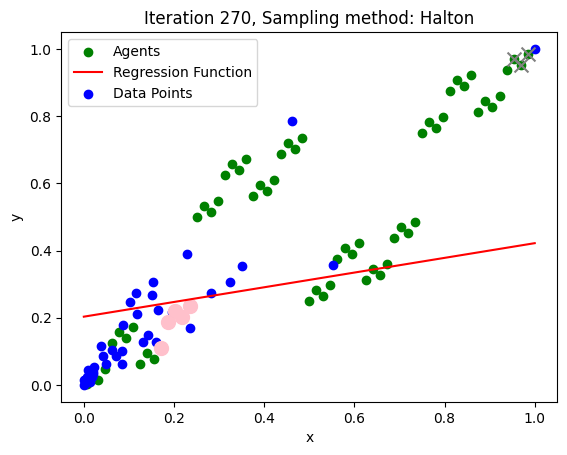

Iteration: 300
Iteration: 301
Test MSE: 1045428.035045


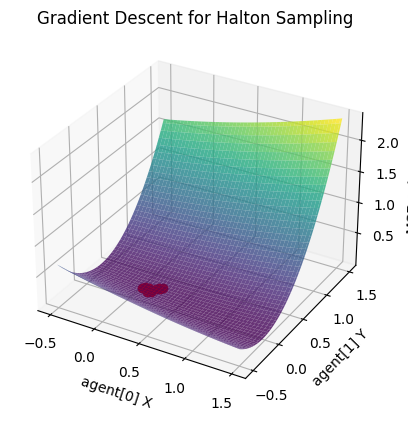

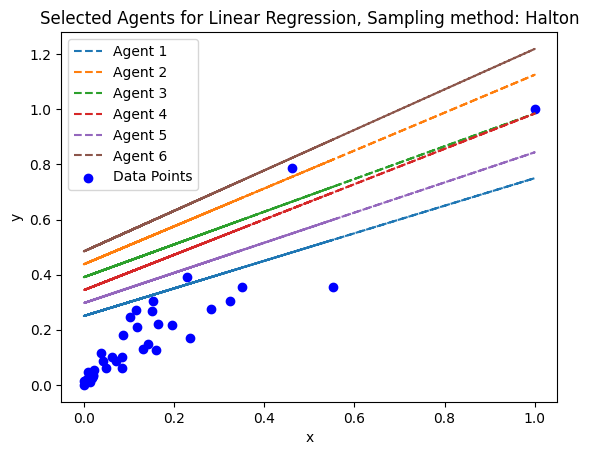

Running DE with UD sampling...


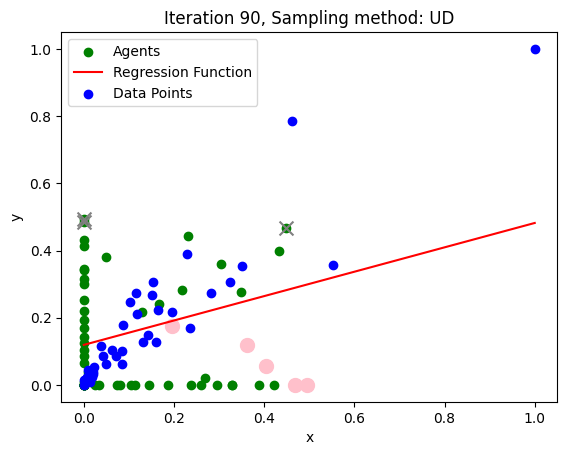

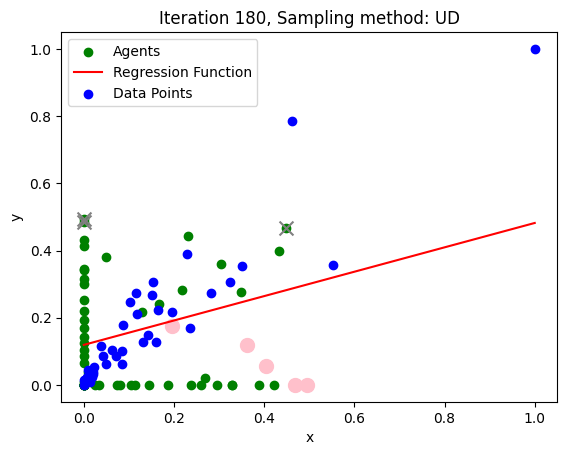

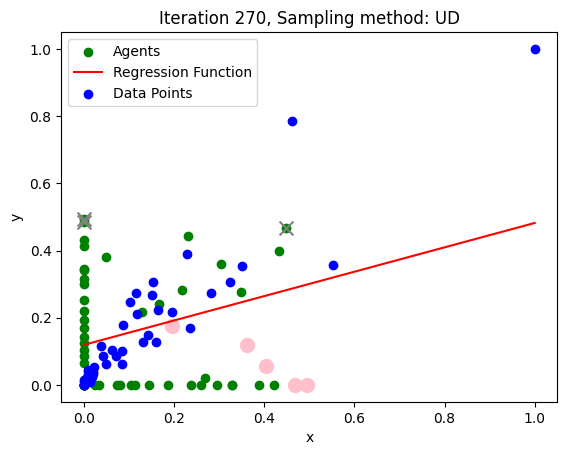

Iteration: 300
Iteration: 301
Test MSE: 638144.323149


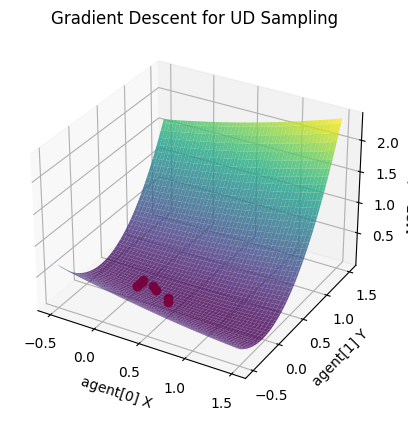

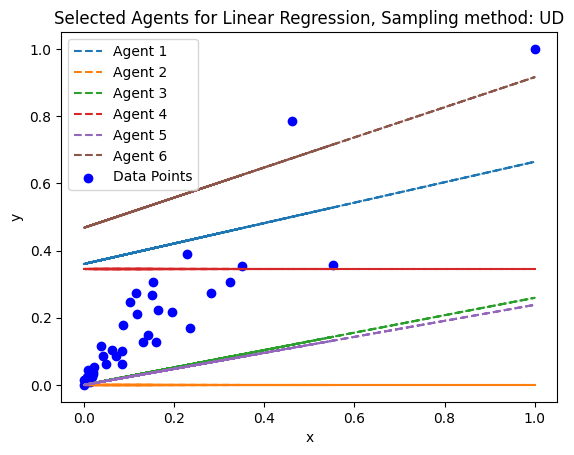

Running DE with Random sampling...


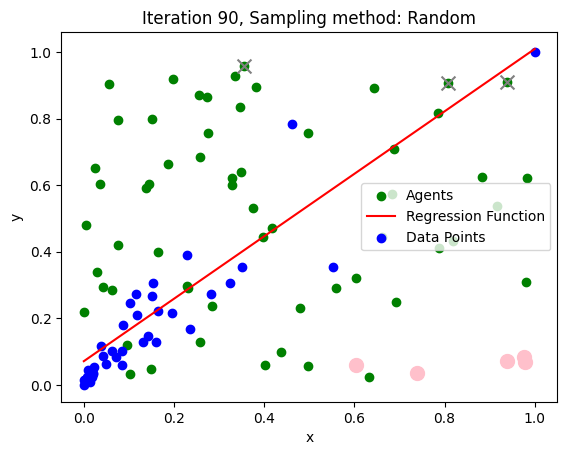

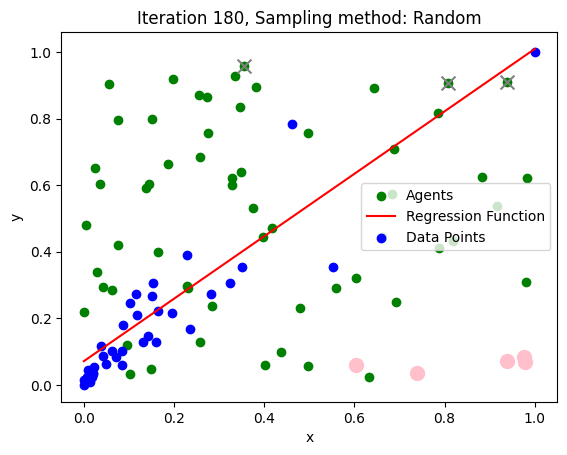

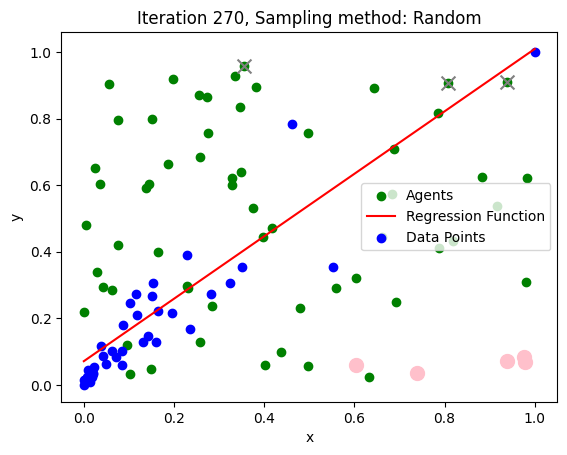

Iteration: 300
Iteration: 301
Test MSE: 1249827.959232


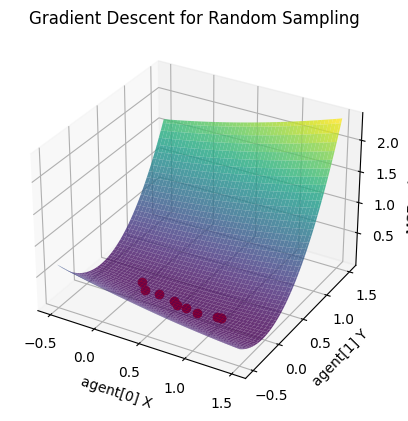

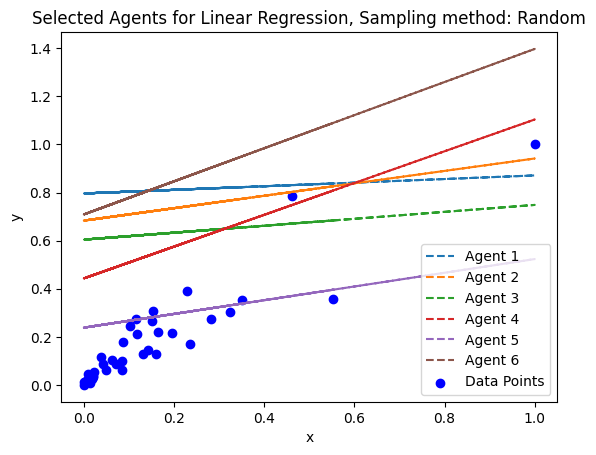

Running DE with CSFD sampling...


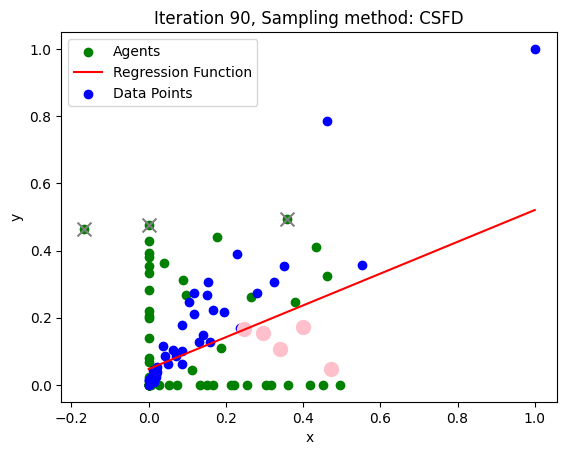

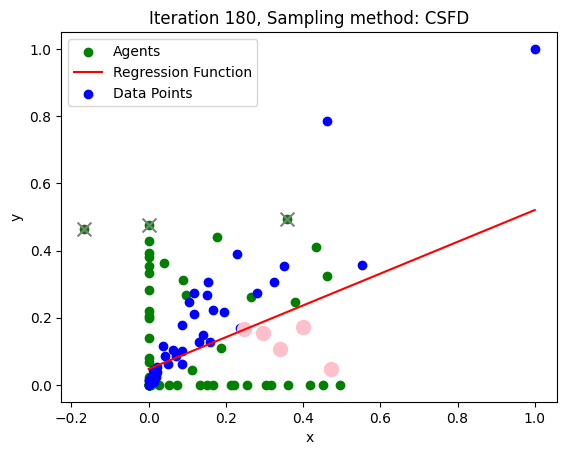

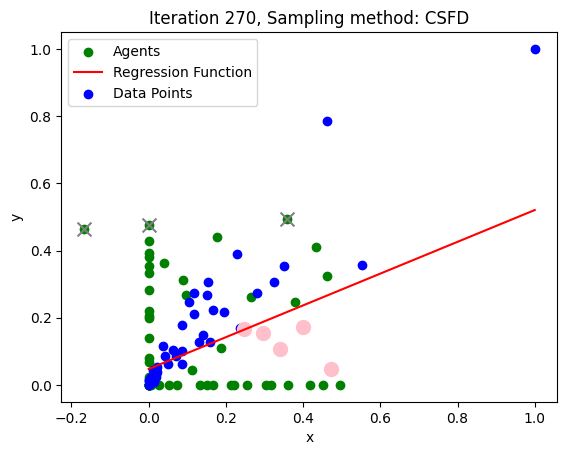

Iteration: 300
Iteration: 301
Test MSE: 387310.077134


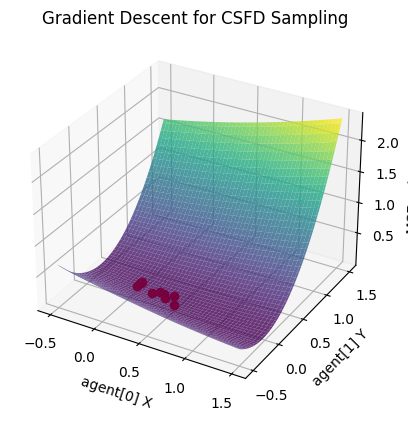

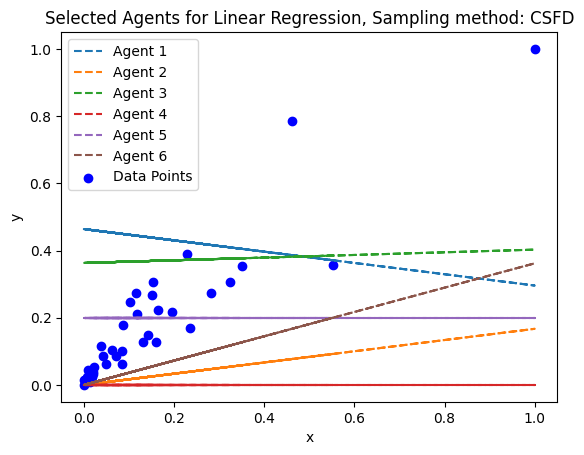


Best results for LHS:
Best parameters: [25775594.973586414, 254.01009702867972]
Best MSE: 0.008769


Best results for Sobol:
Best parameters: [32125579.787829556, 93.3167332150042]
Best MSE: 0.007584


Best results for Halton:
Best parameters: [7856344.09375, 871.140625]
Best MSE: 0.030380


Best results for UD:
Best parameters: [12652842.58485394, 529.0565120301876]
Best MSE: 0.020623


Best results for Random:
Best parameters: [31801259.73379943, 333.6721400056999]
Best MSE: 0.007312


Best results for CSFD:
Best parameters: [16321147.269979095, 236.66281696424753]
Best MSE: 0.020411

Best sampling technique based on MSE:
Sampling method: Random
Best parameters: [31801259.73379943, 333.6721400056999]
Best MSE: 0.007311886373565725


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE2 import lhs
from scipy.stats import qmc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# librerias del gradiente
from scipy.optimize import approx_fprime

# The maximum number of Dimensions is established.
dimensions = 2

# Read data from CSV
data = pd.read_csv("Datos.csv")
x = data["493782"].values
y = data["164"].values

# Split the data into training and testing sets (75% for training, 25% for testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Normalize the data based on the training set
x_min, x_max = np.min(x_train), np.max(x_train)
y_min, y_max = np.min(y_train), np.max(y_train)
x = (x_train - x_min) / (x_max - x_min)
y = (y_train - y_min) / (y_max - y_min)

x_test = (x_test - x_min) / (x_max - x_min)  # Normalize test data using the same min and max
y_test = (y_test - y_min) / (y_max - y_min)

# Adjust the search space based on the normalized data range
f_range = np.array([[0, 1], [0, 1]])

# The maximum number of iterations is established.
max_iter = 300

# Create regression data
#x, y = generate_regression_data(num_points=100, noise_stddev=0.1)

# Number of agents
num_agents = 64


# Function to initialize the population using different sampling techniques
def initialize_population(dimensions, f_range, num_agents, sampling_technique):
    if sampling_technique == "LHS":
        samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=800)
        agents = f_range[:, 0] + samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Sobol":
        sobol_samples = qmc.Sobol(d=dimensions).random(num_agents)
        agents = f_range[:, 0] + sobol_samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Halton":
        def halton_single(index, base):
            result = 0.0
            f = 1.0 / base
            i = index
            while i > 0:
                result += f * (i % base)
                i = int(i / base)
                f /= base
            return result

        agents = np.empty((num_agents, dimensions))
        for i in range(dimensions):
            sequence = np.zeros(num_agents)
            for j in range(num_agents):
                sequence[j] = halton_single(j + 1, 2 + i * 2)
            agents[:, i] = f_range[i, 0] + sequence * (f_range[i, 1] - f_range[i, 0])
    elif sampling_technique == "UD":
        ud_samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=800)
        centered_samples = ud_samples - 0.5
        agents = f_range[:, 0] + centered_samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Random":
        agents = np.random.rand(num_agents, dimensions) * (f_range[:, 1] - f_range[:, 0]) + f_range[:, 0]
    elif sampling_technique == "CSFD":
        lhs_samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=800)
        centered_samples = lhs_samples - 0.5
        agents = f_range[:, 0] + centered_samples * (f_range[:, 1] - f_range[:, 0])
    else:
        raise ValueError("Invalid sampling technique")

    return agents


def differential_evolution(agents, max_iter, m, cross_p, plot_interval=90, technique=None):
    dimensions = agents.shape[1]
    num_agents = agents.shape[0]
    best_params = None
    best_mse = np.inf
    mse = np.empty(num_agents)
    fitness = np.empty(num_agents)

    x_reg = np.linspace(0, 1, 100)

    selected_agents = []  # Create a list to store selected agents in each iteration

    gradients = []  # Create an array to store gradients


    for i in range(num_agents):
        params = agents[i]
        y_pred = params[0] * x + params[1]
        mse[i] = np.mean((y - y_pred) ** 2)


        # Calculate the gradient using approx_fprime
        gradient = approx_fprime(params, lambda p: np.mean((y - (p[0] * x + p[1])) ** 2), epsilon=1e-6)
        gradients.append(gradient)  # Store the gradient for the current agent


        if mse[i] < best_mse:
            best_params = params
            best_mse = mse[i]

    iter = 1
    while iter <= max_iter:
        selected_agents_iteration = []  # List to store selected agents in this iteration
        for i in range(num_agents):
            # five different individuals are chosen.
            indexes = np.arange(num_agents)
            indexes = indexes[indexes != i]
            indexes = np.random.choice(indexes, 5, replace=False)
            agents_selected = agents[indexes]

            # The crossover operation is performed to obtain the mutant vector.
            mut = agents_selected[0] + m * (agents_selected[1] - agents_selected[2])

            # The differential mutation of the DE algorithm is performed.
            prob_vector = np.random.rand(dimensions) <= cross_p
            mut = agents[i] * prob_vector + mut * np.logical_not(prob_vector)


            # Calculate the gradient using approx_fprime
            gradient = approx_fprime(agents[i], lambda p: np.mean((y - (p[0] * x + p[1])) ** 2), epsilon=1e-6)
            gradients[i] = gradient  # Store the gradient for the current agent

            # It is verified that the generated vector is within the search space defined by the upper and lower limits.
            for j in range(dimensions):
                upper_limit = f_range[j, 1]
                lower_limit = f_range[j, 0]

                if mut[j] < lower_limit:
                    mut[j] = lower_limit
                elif mut[j] > upper_limit:
                    mut[j] = upper_limit

            # Calculate the fitness of the mutant vector
            y_pred_mut = mut[0] * x + mut[1] # Calculate predicted values for the mutant
            mse_mut = np.mean((y - y_pred_mut) ** 2)  # Calculate MSE for the mutant

            # The replacement mechanism is then performed.
            if mse_mut < mse[i]:
                agents[i] = mut
                mse[i] = mse_mut
                if mse[i] < best_mse:
                    best_params = agents[i]
                    best_mse = mse[i]

            # Update the y_reg line with the current best_params
            y_reg = best_params[0] * x_reg + best_params[1]

            # Check if this agent was selected for linear regression
            if i%12 == 0:
                selected_agents_iteration.append(agents[i])

        selected_agents.append(selected_agents_iteration)

        # Add print statements for debugging
        #print(f"Iteration {iter} - Best MSE: {best_mse}, Best Params: {best_params}")

# Visualize the agents' positions and the regression function at specific iterations
        if iter % plot_interval == 0:

            plt.figure()
            plt.scatter(agents[:, 0], agents[:, 1], label="Agents", color='green')
            y_reg = best_params[0] * x_reg + best_params[1]  # Update y_reg for current best_params
            plt.plot(x_reg, y_reg, label="Regression Function", color='red')
            plt.scatter(x, y, label="Data Points", color='blue')
            plt.title(f"Iteration {iter}, Sampling method: {technique}")
            plt.xlabel("x")
            plt.ylabel("y")
            # Select 3 worst and 5 best agents for visualization
            worst_agents = [agents[i] for i in np.argsort(mse)[-3:]]
            best_agents = [agents[i] for i in np.argsort(mse)[:5]]

             # Plot the 3 worst agents
            for agent in worst_agents:
              plt.scatter(agent[0], agent[1],  color='gray', marker='x', s=100)

            # Plot the 5 best agents
            for agent in best_agents:
              plt.scatter(agent[0], agent[1],  color='pink', marker='o', s=100)

            plt.legend()
            plt.show()

        iter += 1
        if iter > 299:
            print("Iteration:", iter)

    return best_params, best_mse ,selected_agents ,gradients


# List of sampling techniques to compare
sampling_techniques = ["LHS", "Sobol", "Halton", "UD", "Random", "CSFD"]

# Dictionary to store the results
results = {}

# Dictionary to store fitness values for each technique
fitness_values = {}

# Run DE for each sampling technique and store the results and selected agents
for technique in sampling_techniques:
    print(f"Running DE with {technique} sampling...")
    agents = initialize_population(dimensions, f_range, num_agents, technique)

    # default m and cross_p (0.5 , 0.2)
    best_params, best_mse, selected_agents, gradients = differential_evolution(agents, max_iter, 3.6, 1.7, technique=technique)

    # Denormalize the best parameters
    best_params_denormalized = [
      best_params[0] * (x_max - x_min) + x_min,
      best_params[1] * (y_max - y_min) + y_min
    ]

    # Make predictions on the normalized test set
    y_pred_test_normalized = best_params[0] * x_test + best_params[1]

    # Denormalize the predictions
    y_pred_test = y_pred_test_normalized * (y_max - y_min) + y_min

    # Calculate the Mean Squared Error (MSE) on the denormalized test set
    test_mse = mean_squared_error(y_test, y_pred_test)

    # Print the test MSE to evaluate the model's performance
    print(f"Test MSE: {test_mse:.6f}")

    results[technique] = (best_params_denormalized, best_mse)

    # Select agents with the smallest gradients
    num_agents_to_mutate = 10  # You can adjust the number of agents to mutate
    selected_agents_with_smallest_gradients = [agents[i] for i in np.argsort(np.linalg.norm(gradients, axis=1))[:num_agents_to_mutate]]
    # Create a 3D plot to visualize gradient descent
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a grid of parameter values for visualization
    x_grid = np.linspace(-0.5, 1.5, 100)
    y_grid = np.linspace(-0.5, 1.5, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.zeros_like(X)

    # Calculate the MSE for each combination of parameters
    for i in range(100):
        for j in range(100):
            Z[i, j] = np.mean((y - (X[i, j] * x + Y[i, j])) ** 2)

    # Plot the surface of the MSE
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

    # Plot the selected agents' path in the parameter space
    for agent in selected_agents_with_smallest_gradients:
        ax.plot(agent[0], agent[1], np.mean((y - (agent[0] * x + agent[1])) ** 2), marker='o', color='red')

    ax.set_xlabel('agent[0] X')
    ax.set_ylabel('agent[1] Y')
    ax.set_zlabel('MSE calculado')

    plt.title(f"Gradient Descent for {technique} Sampling")

    plt.show()

    # Store the fitness value
    fitness_values[technique] = best_mse

    # Retrieve the selected agents for the last iteration
    selected_agents_last_iteration = selected_agents[-1]

    # Create a plot for the selected agents
    plt.figure()
    for i, agent in enumerate(selected_agents_last_iteration):
        y_reg_selected = agent[0] * x + agent[1]
        plt.plot(x, y_reg_selected, label=f"Agent {i + 1}", linestyle='--')

    # Update the y_reg line with the best_params for this technique
    y_reg = best_params[0] * x + best_params[1]

    plt.scatter(x, y, label="Data Points", color='blue')
    plt.title(f"Selected Agents for Linear Regression, Sampling method: {technique}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Print the best results for each sampling method
for method, result in results.items():
    print(f"\nBest results for {method}:")
    print(f"Best parameters: {result[0]}")
    print(f"Best MSE: {result[1]:.6f}\n")  # Format MSE with 6 decimal places

# Determine the "best technique" based on the lowest MSE value
best_technique = min(fitness_values, key=lambda k: fitness_values[k])
best_params = results[best_technique][0]
best_mse = results[best_technique][1]

# Print the best results
print("Best sampling technique based on MSE:")
print(f"Sampling method: {best_technique}")
print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")